In [1]:
import pandas as pd

In [2]:
# Read the data from the CSV file
df = pd.read_csv(r'c:\Users\Victus\Desktop\AI Email Assistant\data\twcs\cleaned_twcs.csv', encoding='utf-8')
df.head()

,tweet_id,author_id,inbound,created_at,response_tweet_id,in_response_to_tweet_id,cleaned_text
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,2,3.0,understand would like assist would need privat...
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,NaN,1.0,NaN
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,1,4.0,sprintcar send sever privat messag one respond...
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,3,5.0,send privat messag assist just click top profil
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,4,6.0,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83017 entries, 0 to 83016
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   tweet_id                 83017 non-null  int64  
 1   author_id                83017 non-null  object 
 2   inbound                  83017 non-null  bool   
 3   created_at               83017 non-null  object 
 4   response_tweet_id        56009 non-null  object 
 5   in_response_to_tweet_id  61477 non-null  float64
 6   cleaned_text             63830 non-null  object 
dtypes: bool(1), float64(1), int64(1), object(4)
memory usage: 3.9+ MB


In [4]:
df['author_id'].value_counts().reset_index()

,author_id,count
0,AmazonHelp,5823
1,AppleSupport,2583
2,Uber_Support,1704
3,Tesco,1120
4,SpotifyCares,1054
...,...,...
22933,126130,1
22934,126132,1
22935,126133,1
22936,126135,1


In [5]:
df = df.drop(['tweet_id', 'created_at', 'response_tweet_id', 'in_response_to_tweet_id'], axis=1)

In [6]:
print(df.head())

    author_id  inbound                                       cleaned_text
0  sprintcare    False  understand would like assist would need privat...
1      115712     True                                                NaN
2      115712     True  sprintcar send sever privat messag one respond...
3  sprintcare    False    send privat messag assist just click top profil
4      115712     True                                                NaN


In [7]:
df['cleaned_text'].isna().sum()

19187

In [8]:
df = df.dropna(subset=["cleaned_text"])
print("After dropping rows with missing 'cleaned_text':", df.shape)

After dropping rows with missing 'cleaned_text': (63830, 3)


In [9]:
df.shape

(63830, 3)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63830 entries, 0 to 83015
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   author_id     63830 non-null  object
 1   inbound       63830 non-null  bool  
 2   cleaned_text  63830 non-null  object
dtypes: bool(1), object(2)
memory usage: 1.5+ MB


## Feature Extraction

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

df = df[df["inbound"] == True]

vectorizer = TfidfVectorizer(max_features=200, stop_words="english")
X = vectorizer.fit_transform(df["cleaned_text"])  # Orijinal metinle çalış

In [12]:
from sklearn.decomposition import LatentDirichletAllocation

# LDA modelini oluştur ve eğit
num_topics = 5  # Çıkarılacak konu sayısı (istersen artırabiliriz)
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X)

LatentDirichletAllocation(n_components=5, random_state=42)

In [13]:
# En sık geçen kelimeleri içeren konuları göster
def print_topics(model, vectorizer, top_n=10):
    words = vectorizer.get_feature_names_out()
    for idx, topic in enumerate(model.components_):
        print(f"📌 **Konu {idx+1}:** ", [words[i] for i in topic.argsort()[:-top_n - 1:-1]])

print_topics(lda, vectorizer)

📌 **Konu 1:**  ['thank', 'britishairway', 'flight', 'southwestair', 'americanair', 'delta', 'great', 'love', 'argoshelp', 'atviassist']
📌 **Konu 2:**  ['chipotletweet', 'tesco', 'account', 'card', 'custom', 'microsofthelp', 'askplayst', 'ideacar', 'morrison', 'support']
📌 **Konu 3:**  ['amazonhelp', 'order', 'o2', 'say', 'day', 'email', 'look', 'month', 'packag', 'deliveri']
📌 **Konu 4:**  ['applesupport', 'updat', 'fix', 'app', 'work', 'phone', 'marksandspenc', 'whi', 'iphon', '115858']
📌 **Konu 5:**  ['servic', 'ubersupport', 'virgintrain', 'train', 'gwrhelp', 'swhelp', 'sainsburi', 'askspectrum', 'internet', 'ticket']


In [14]:
import numpy as np

# Her e-posta için en olası konuyu belirle
topic_results = lda.transform(X)
df["topic"] = np.argmax(topic_results, axis=1)

# İlk 10 satırı göster
print(df[["cleaned_text", "topic"]].head(10))

                                         cleaned_text  topic
2   sprintcar send sever privat messag one respond...      1
6                         sprintcar bad custom servic      1
8      sprintcar you gonna chang connect whole famili      4
10                          sprintcar sinc sign day 1      3
12  115714 y’all lie connect 5 bar lte still won’t...      4
14  115714 whenev contact custom support tell enab...      1
16  askspectrum would like email copi one sinc spe...      4
18    askspectrum receiv corpor offic would like copi      2
20  askspectrum the correct way via account email ...      1
21  askspectrum that inform form front need mainta...      4


In [15]:
topic_labels = {
    0: "General Support",
    1: "Fly / Airline Issues",
    2: "Order / Payment Issues",
    3: "Retail / Grocery Store Complaints",
    4: "Tech Support"
}

# Konu numaralarını anlamlı etiketlere çevir
df["topic_label"] = df["topic"].map(topic_labels)

# İlk 10 satırı göster
print(df[["cleaned_text", "topic_label"]].head(10))

                                         cleaned_text  \
2   sprintcar send sever privat messag one respond...   
6                         sprintcar bad custom servic   
8      sprintcar you gonna chang connect whole famili   
10                          sprintcar sinc sign day 1   
12  115714 y’all lie connect 5 bar lte still won’t...   
14  115714 whenev contact custom support tell enab...   
16  askspectrum would like email copi one sinc spe...   
18    askspectrum receiv corpor offic would like copi   
20  askspectrum the correct way via account email ...   
21  askspectrum that inform form front need mainta...   

                          topic_label  
2                Fly / Airline Issues  
6                Fly / Airline Issues  
8                        Tech Support  
10  Retail / Grocery Store Complaints  
12                       Tech Support  
14               Fly / Airline Issues  
16                       Tech Support  
18             Order / Payment Issues  
20          

In [16]:
from sklearn.model_selection import train_test_split

# Veri kümesini temizleyelim
df = df.dropna(subset=["cleaned_text", "topic_label"])  # Boş satırları sil

# X (metin) ve Y (etiket) olarak ayır
X = df["cleaned_text"]
y = df["topic_label"]

# TF-IDF ile metni vektörleştir
X_tfidf = vectorizer.fit_transform(X)


import joblib

# Eğitilmiş TF-IDF vektörleştiriciyi kaydet
joblib.dump(vectorizer, r'C:\Users\Victus\Desktop\AI Email Assistant\models\tfidf_vectorizer.pkl')

# Eğitim ve test setlerine ayır
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.15, stratify=y, random_state=42)

print("Veri başarıyla hazırlandı! 🚀")
print("Eğitim kümesi boyutu:", X_train.shape)
print("Test kümesi boyutu:", X_test.shape)


Veri başarıyla hazırlandı! 🚀
Eğitim kümesi boyutu: (29091, 200)
Test kümesi boyutu: (5134, 200)


In [17]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder


# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

joblib.dump(label_encoder, r'C:\Users\Victus\Desktop\AI Email Assistant\models\label_encoder.pkl')


svm = SVC(random_state=42, probability=True)

# Hiperparametre araması yapalım
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(svm, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train_encoded)

# En iyi model ile tahmin yapalım
y_pred = grid_search.best_estimator_.predict(X_test)

# Sonuçları yazdıralım
print(f"\n📊 En iyi model doğruluk skoru: {accuracy_score(y_test_encoded, y_pred)}")
print("\nClassification Report:\n", classification_report(y_test_encoded, y_pred))



📊 En iyi model doğruluk skoru: 0.9511102454226724

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95      1008
           1       0.95      0.94      0.94       919
           2       0.95      0.95      0.95      1240
           3       0.96      0.95      0.95       940
           4       0.95      0.96      0.96      1027

    accuracy                           0.95      5134
   macro avg       0.95      0.95      0.95      5134
weighted avg       0.95      0.95      0.95      5134



In [22]:
# Save the best model from grid search
best_model = grid_search.best_estimator_

# Save the model to a file
joblib.dump(best_model, r'C:\Users\Victus\Desktop\AI Email Assistant\models\svm_model.pkl')

['C:\\Users\\Victus\\Desktop\\AI Email Assistant\\models\\svm_model.pkl']

In [23]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Perform cross-validation
cross_val_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train_encoded, cv=5, scoring='accuracy')

print(f"Cross-Validation Scores: {cross_val_scores}")
print(f"Average Cross-Validation Accuracy: {np.mean(cross_val_scores)}")


Cross-Validation Scores: [0.94414848 0.95084221 0.94963905 0.94946717 0.95084221]
Average Cross-Validation Accuracy: 0.9489878257655855


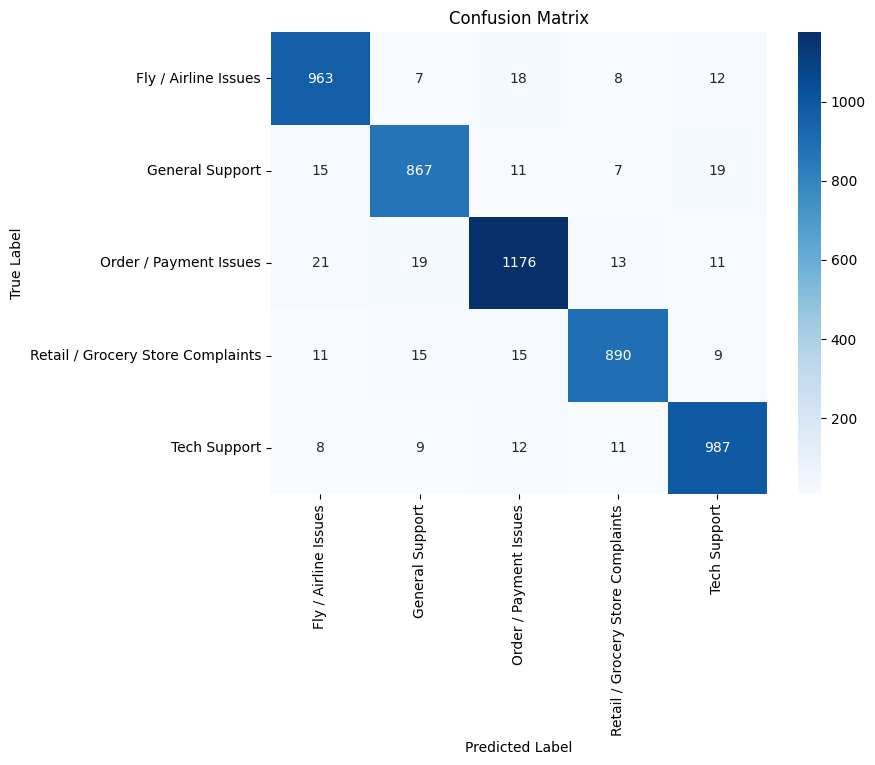

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()


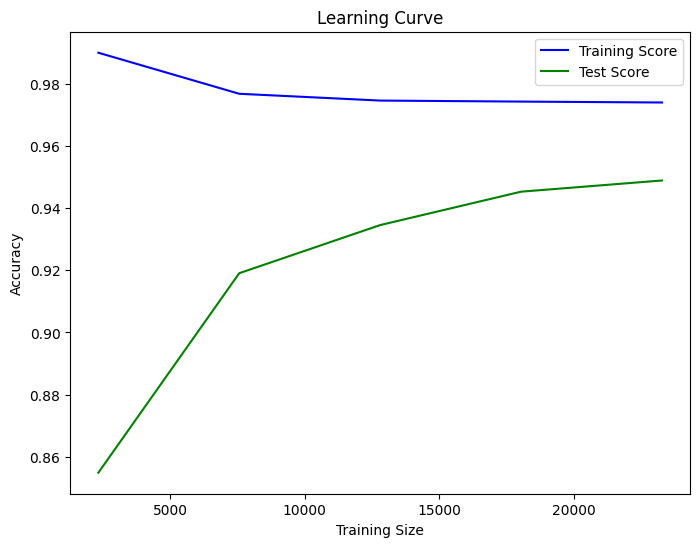

In [25]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    grid_search.best_estimator_, X_train, y_train_encoded, cv=5, scoring='accuracy', n_jobs=-1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score', color='blue')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Test Score', color='green')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()


In [18]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from xgboost import XGBClassifier


xgb = XGBClassifier(colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=3, use_label_encoder=False, eval_metric="mlogloss")
xgb.fit(X_train, y_train_encoded)

y_pred_xgb = xgb.predict(X_test)

print("📊 XGBoost Doğruluk Skoru:", accuracy_score(y_test_encoded, y_pred_xgb))
print(classification_report(y_test_encoded, y_pred_xgb, target_names=label_encoder.classes_))

c:\Users\Victus\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [17:46:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📊 XGBoost Doğruluk Skoru: 0.6634203350214258
                                   precision    recall  f1-score   support

             Fly / Airline Issues       0.77      0.57      0.66      1008
                  General Support       0.75      0.54      0.63       919
           Order / Payment Issues       0.50      0.85      0.63      1240
Retail / Grocery Store Complaints       0.79      0.61      0.69       940
                     Tech Support       0.80      0.69      0.74      1027

                         accuracy                           0.66      5134
                        macro avg       0.72      0.65      0.67      5134
                     weighted avg       0.71      0.66      0.67      5134



In [19]:
# from sklearn.model_selection import GridSearchCV
# from xgboost import XGBClassifier

# # XGBoost modelini oluştur
# model_xgb = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")

# # Denenecek parametreler
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [3, 6, 9],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.8, 0.9, 1.0]
# }

# # GridSearchCV ile hiperparametre optimizasyonu
# grid_search = GridSearchCV(estimator=model_xgb, param_grid=param_grid, 
#                            scoring='accuracy', cv=3, verbose=1, n_jobs=-1)

# # Eğitim verisiyle hiperparametre optimizasyonu yap
# grid_search.fit(X_train, y_train_encoded)



# # En iyi parametreleri ve doğruluk skorunu yazdır
# print("En iyi parametreler:", grid_search.best_params_)
# print("En iyi doğruluk skoru:", grid_search.best_score_)

# # En iyi model ile tahmin yap
# best_model = grid_search.best_estimator_
# y_pred_best = best_model.predict(X_test)

# # Sonuçları yazdır
# print("📊 İyileştirilmiş XGBoost Doğruluk Skoru:", accuracy_score(y_test_encoded, y_pred_best))
# print(classification_report(y_test_encoded, y_pred_best, target_names=label_encoder.classes_))


In [20]:
# best_params = {
#     "colsample_bytree": 0.8,
#     "learning_rate": 0.1,
#     "max_depth": 9,
#     "n_estimators": 300,
#     "subsample": 0.8
# }

# model_xgb = XGBClassifier(**best_params)
# model_xgb.fit(X_train, y_train_encoded)